# Gender Classification

In [1]:
import os
import pandas as pd
import librosa 
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torch.optim.adam
from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io.wavfile import write

from IPython.display import Audio

# import date time
from datetime import datetime

### Hardware for training

the following lines determine on what hardware the neural network is gonne be trained on. Luckily there is some hardware available which should enable faster training due to usage of GPU.

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

CUDA available: True
CUDA version: 12.4
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
Using device: cuda


This are some Constant which are used for accessing data from the f

In [3]:
IMAGE_PATH = '../doc/images/' # path to save images for LaTeX import
AUDIO_PATH = 'data/cv-corpus-16.1-delta-2023-12-06/en/clips/' # path to audio files
LABEL_PATH = 'data/cv-corpus-16.1-delta-2023-12-06/en/validated.tsv' # path to labels

## Functions

This function saves a table from for example a dataframe to a file in Latex format, so it can be imported easily

In [4]:
def table_to_latex(df: pd.DataFrame, filename: str) -> None:
    """
    Exports a pandas DataFrame to a LaTeX file.

    Parameters:
    - df (pd.DataFrame): The DataFrame to export.
    - filename (str): The name of the file (without extension) where the LaTeX table will be saved.
    """
    # Generate LaTeX code from the DataFrame
    latex_code = df.to_latex(index=False, escape=True)

    
    with open(f"../doc/tables/{filename}.tex", "w") as f:
        f.write(latex_code)


## Data Analyses

### Load labels

In [5]:
labels = pd.read_csv(LABEL_PATH, sep='\t', header=0,) # load labels from tsv file
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3408 entries, 0 to 3407
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   client_id   3408 non-null   object 
 1   path        3408 non-null   object 
 2   sentence    3408 non-null   object 
 3   up_votes    3408 non-null   int64  
 4   down_votes  3408 non-null   int64  
 5   age         3079 non-null   object 
 6   gender      3076 non-null   object 
 7   accents     3188 non-null   object 
 8   variant     0 non-null      float64
 9   locale      3408 non-null   object 
 10  segment     0 non-null      float64
dtypes: float64(2), int64(2), object(7)
memory usage: 293.0+ KB


### Filtering

gender
male      1528
female    1498
other       50
Name: count, dtype: int64
gender
0    1498
1    1498
Name: count, dtype: int64


/tmp/ipykernel_15659/2102005493.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels['gender'] = labels['gender'].replace({'male': 0, 'female': 1}).astype(int)


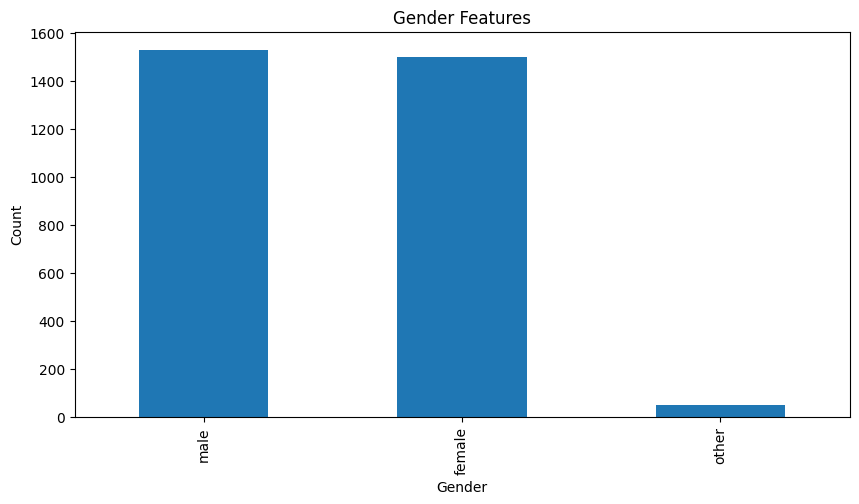

In [6]:
# drop unecesary columns
labels = labels.drop(columns=['client_id',
                              'up_votes', 
                              'down_votes', 
                              'accents', 
                              'locale', 
                              'segment', 
                              'variant', 
                              'sentence',])

# drop rows with missing values
labels = labels.dropna(subset=['gender'])
print(labels['gender'].value_counts())

# Create the bar plot
gender_feature_plot = labels['gender'].value_counts().plot(kind='bar', figsize=(10, 5))
gender_feature_plot.set_title('Gender Features')  # Set title for the plot
gender_feature_plot.set_xlabel('Gender')          # Set x-axis label
gender_feature_plot.set_ylabel('Count')           # Set y-axis label

experiment_labels = labels[labels['gender'].isin(['other'])]

# Filter the DataFrame to keep only rows where 'gender' is 'male' or 'female'
labels = labels[labels['gender'].isin(['male', 'female'])]


# replace the string values with integers
labels['gender'] = labels['gender'].replace({'male': 0, 'female': 1}).astype(int)

# Count the number of samples in each class
male_count = labels[labels['gender'] == 0].shape[0]
female_count = labels[labels['gender'] == 1].shape[0]

# Determine the minority class count
min_count = min(male_count, female_count)

# Randomly sample the majority class
balanced_labels = pd.concat([
    labels[labels['gender'] == 0].sample(n=min_count, random_state=42),
    labels[labels['gender'] == 1].sample(n=min_count, random_state=42)
])

print(balanced_labels['gender'].value_counts())

labels = balanced_labels


### Exports

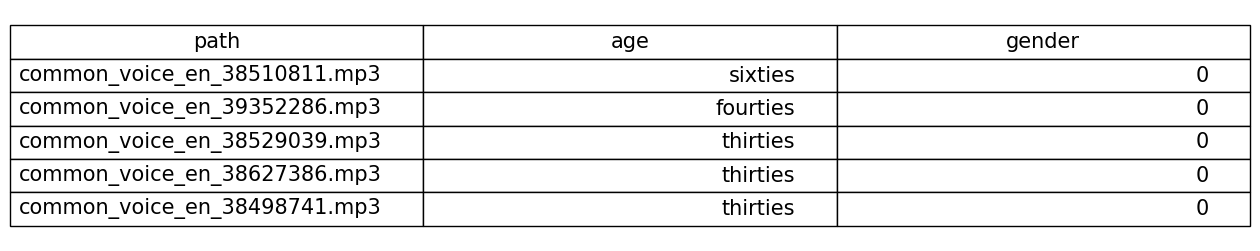

In [7]:
# Save the figure
fig = gender_feature_plot.get_figure()
fig.savefig(IMAGE_PATH + 'gender_features.png', dpi=600, bbox_inches='tight', transparent=True)
table_to_latex(labels.head(), 'features')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 3))  # Adjust figsize for better image quality
ax.axis('tight')
ax.axis('off')

# Render the table
table = ax.table(cellText=labels.head().values, colLabels=labels.head().columns, loc='center')
# Adjust font size
table.auto_set_font_size(False) 
table.set_fontsize(15) 
table.scale(1, 2)  


## Signal Processing

### Audio output

In [8]:
def listen(paths, path_idx=0):
    # Update paths with the base directory path
    paths = [os.path.join(AUDIO_PATH, path) for path in labels['path'].values]

    # Load the audio file (example: first file in paths list)
    audio_data, sample_rate = librosa.load(paths[path_idx], sr=None)  # `sr=None` keeps the original sample rate
    # print(f"Number of samples: {len(audio_data)}, sample rate: {sample_rate}")
    Audio(audio_data, rate=sample_rate)

In [9]:
paths = [os.path.join(AUDIO_PATH, path) for path in labels['path'].values]
for path in paths[:10]:
    audio_data, sample_rate = librosa.load(path, sr=None)
    #audio_data = librosa.effects.trim(audio_data, top_db=30)[0]  # Trim silent edges
    print(f"Number of samples: {len(audio_data)}, sample rate: {sample_rate}, Time: {len(audio_data)/sample_rate:.2f} seconds")

Number of samples: 176256, sample rate: 32000, Time: 5.51 seconds
Number of samples: 251136, sample rate: 32000, Time: 7.85 seconds
Number of samples: 228096, sample rate: 32000, Time: 7.13 seconds
Number of samples: 144000, sample rate: 32000, Time: 4.50 seconds
Number of samples: 109440, sample rate: 32000, Time: 3.42 seconds
Number of samples: 173952, sample rate: 32000, Time: 5.44 seconds
Number of samples: 274176, sample rate: 32000, Time: 8.57 seconds
Number of samples: 185472, sample rate: 32000, Time: 5.80 seconds
Number of samples: 192384, sample rate: 32000, Time: 6.01 seconds
Number of samples: 294912, sample rate: 32000, Time: 9.22 seconds


### Waveform

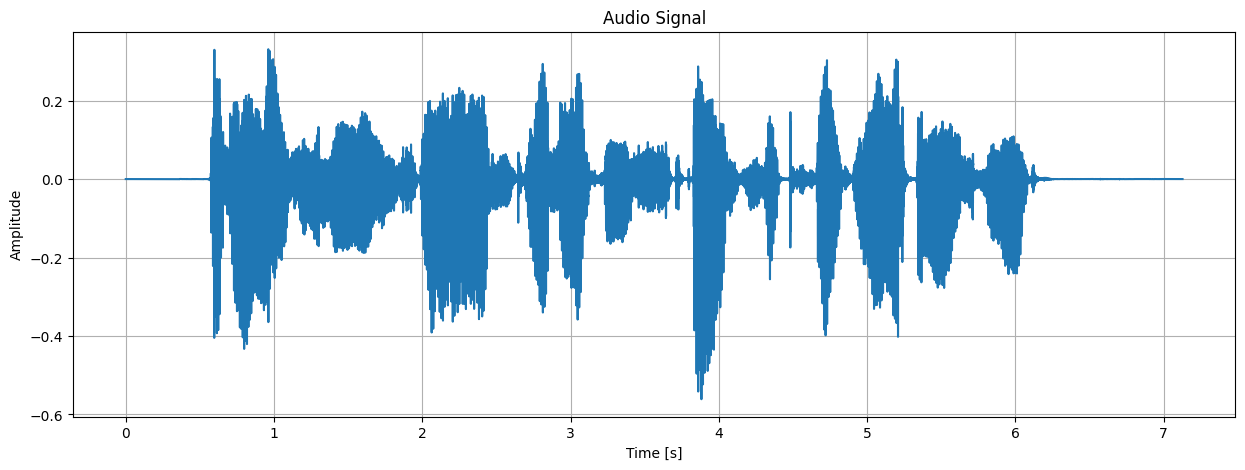

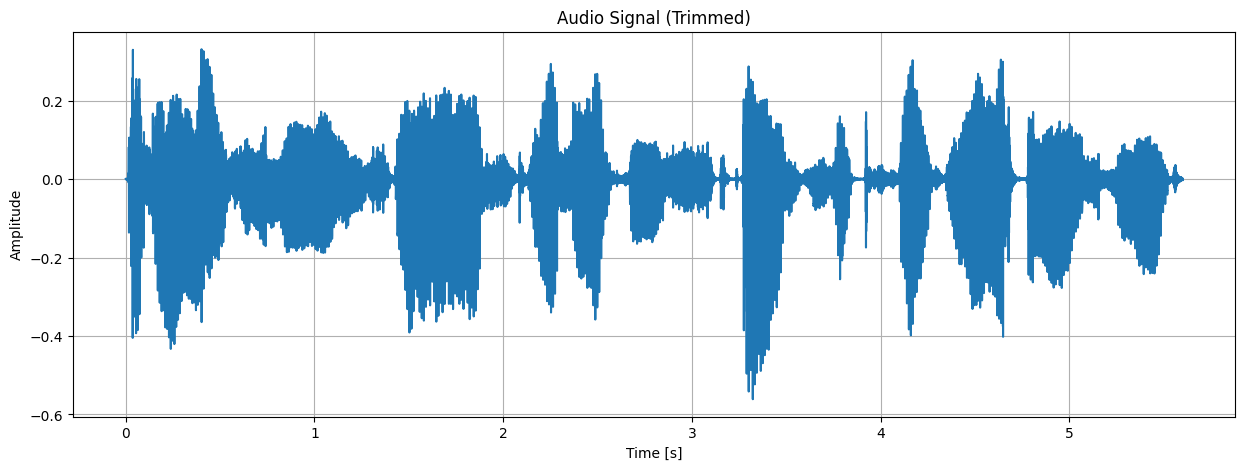

In [10]:
audio_data, sample_rate = librosa.load(paths[2], sr=None)

title = 'Audio Signal'
t = np.linspace(0, len(audio_data)/sample_rate, len(audio_data))
plt.figure(figsize=(15, 5))
plt.plot(t, audio_data)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title(title)
plt.grid()
plt.savefig(IMAGE_PATH + 'audio_signal.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()


# Trim leading and trailing silence from an audio signal
trimmed_audio = librosa.effects.trim(audio_data, top_db=30)[0]
t = np.linspace(0, len(trimmed_audio)/sample_rate, len(trimmed_audio))

title = 'Audio Signal (Trimmed)'
plt.figure(figsize=(15, 5))
plt.plot(t, trimmed_audio)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title(title)
plt.grid()
plt.savefig(IMAGE_PATH + 'audio_signal_trimmed.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()


### Spectrogram

In [11]:
N = 1024  # FFT window size
hop_length = 256  # Overlap between frames, adjust as needed
window = 'hann'  # Window type

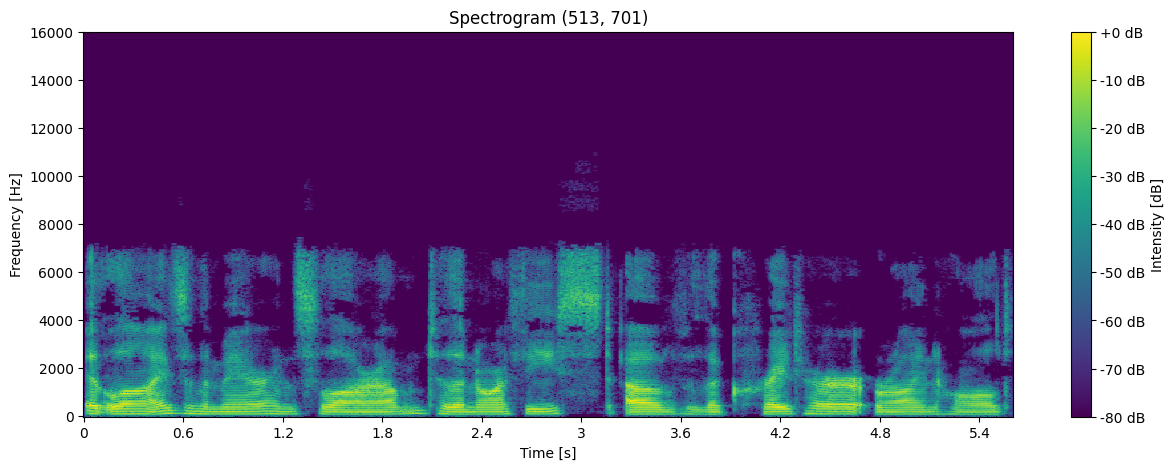

In [12]:
Sx = librosa.stft(trimmed_audio, n_fft=N, hop_length=hop_length, window=window)    # Calculate STFT
Sx_dB = librosa.amplitude_to_db(abs(Sx), ref=np.max)    # spectrogram to dB scale

# Plot the spectrogram
title = f'Spectrogram {Sx_dB.shape}'
fig, ax = plt.subplots(figsize=(15, 5))
img = librosa.display.specshow(Sx_dB, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='hz', cmap='viridis')
ax.set_title(title)
fig.colorbar(img, ax=ax, format="%+2.0f dB", label='Intensity [dB]')
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
fig.savefig(IMAGE_PATH + 'spectrogram' + '.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
# calculate the number of time frames and frequency bins
time_frames = (audio_data.shape[0])/hop_length + 1
time_frames
frequncy_bins = N//2 + 1
time_frames, frequncy_bins

(892.0, 513)

### Melspectrogram

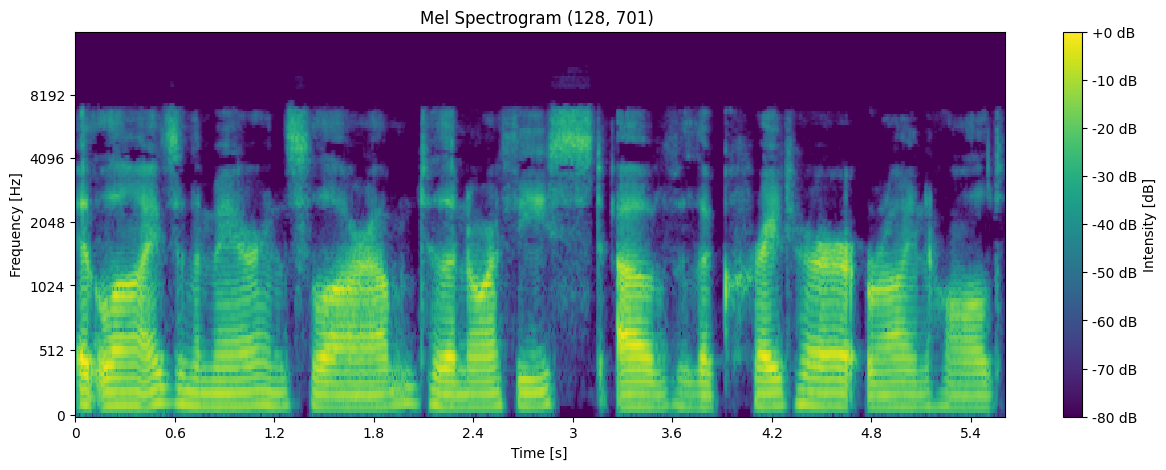

In [14]:
Sx_mel = librosa.feature.melspectrogram(y=trimmed_audio, sr=sample_rate, n_fft=N, hop_length=hop_length)
Sx_mel_dB = librosa.power_to_db(Sx_mel, ref=np.max)

# Plot the mel spectrogram
title = f'Mel Spectrogram {Sx_mel_dB.shape} '
fig, ax = plt.subplots(figsize=(15, 5))
img = librosa.display.specshow(Sx_mel_dB, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis')
ax.set_title(title)
fig.colorbar(img, ax=ax, format="%+2.0f dB", label='Intensity [dB]')
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
fig.savefig(IMAGE_PATH + 'mel-spectrogram' + '.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [15]:
import torch
import torch.nn.functional as F
import librosa
import numpy as np

def extract_mel_spectrogram(audio, sr=22050, n_fft=1024, hop_length=512, n_mels=64, target_shape=(64, 64)):
    """
    Extract a Mel spectrogram from an audio signal and resize it to the target shape.
    
    Parameters:
    - audio: 1D NumPy array containing the audio signal.
    - sr: Sampling rate (default 22050).
    - n_fft: Length of the FFT window (default 1024).
    - hop_length: Number of samples between successive frames (default 512).
    - n_mels: Number of Mel bands (default 64).
    - target_shape: Desired output shape (default (64, 64)).

    Returns:
    - mel_spectrogram: PyTorch tensor of shape [1, 1, target_shape[0], target_shape[1]].
    """
    # Trim leading and trailing silence
    audio = librosa.effects.trim(audio, top_db=30)[0]
    
    # Compute the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    
    # Convert to decibel scale
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Convert to PyTorch tensor
    mel_spectrogram = torch.tensor(mel_spectrogram, dtype=torch.float32)
    
    # Add channel and batch dimensions for resizing
    mel_spectrogram = mel_spectrogram.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]
    
    # Resize to the target shape
    mel_spectrogram = F.interpolate(mel_spectrogram, size=target_shape, mode="bilinear", align_corners=False)
    
    return mel_spectrogram


## Deep Learning

### Dataset

In [16]:
import os
import torch
from torch.utils.data import Dataset
import librosa

class AudioDataset(Dataset):
    def __init__(self, audio_labels, audio_dir, transform=None):
        """
        A PyTorch Dataset for loading audio files and their labels.

        Args:
        - audio_labels (pd.DataFrame): A DataFrame containing audio file names and labels.
        - audio_dir (str): Path to the directory containing audio files.
        - transform (callable, optional): A function/transform to apply to the spectrogram.
        """
        self.labels = audio_labels
        self.dir = audio_dir
        self.transform = transform

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Load an audio sample and its corresponding label.
        
        Args:
        - idx (int): Index of the sample.

        Returns:
        - spec (torch.Tensor): Mel spectrogram of the audio sample (default shape: [64, 64]).
        - label (torch.Tensor): Corresponding label as a tensor (shape: [1]).
        """
        # Load audio file
        audio_path = os.path.join(self.dir, self.labels.iloc[idx, 0])
        if not os.path.exists(audio_path):
            raise FileNotFoundError(f"Audio file not found: {audio_path}")
        
        audio, _ = librosa.load(audio_path, sr=None)  # Load audio with original sampling rate

        # Generate Mel spectrogram
        spec = extract_mel_spectrogram(audio)  # Default shape: [64, 64]

        # Apply optional transformation to the spectrogram
        if self.transform:
            spec = self.transform(spec)
        
        # Retrieve label and convert to tensor
        label = self.labels.iloc[idx, 2]
        label = torch.tensor(label, dtype=torch.long).unsqueeze(0)  # Shape: [1]

        return spec, label


In [17]:
data = AudioDataset(labels, AUDIO_PATH)

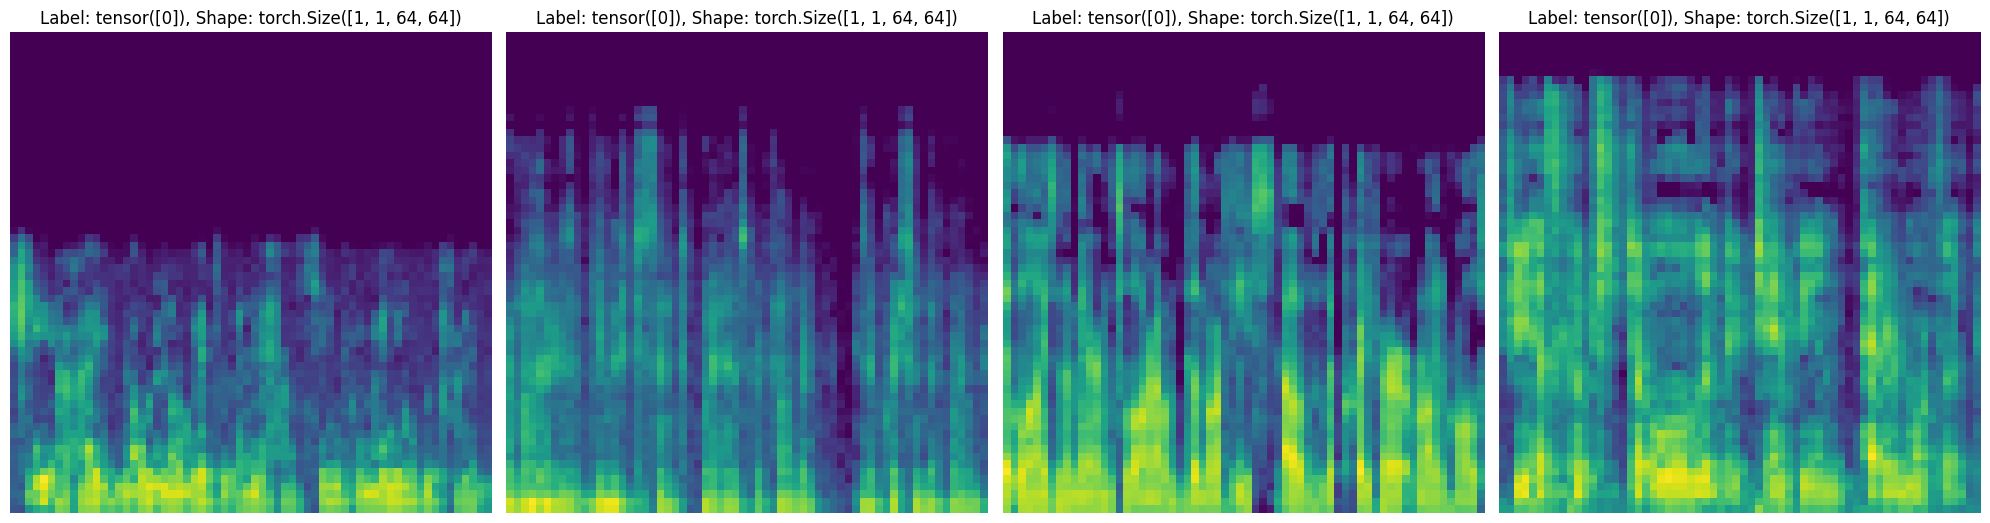

In [18]:
# plot 4 random samples from the dataset
fig, axs = plt.subplots(1,4, figsize=(20, 10))
for i in range(4):
    spec, label = data[i]
    ax = axs[i]
    ax.imshow(spec.squeeze(0).squeeze(0), cmap='viridis', origin='lower')
    ax.set_title(f'Label: {label}, Shape: {spec.shape}')
    ax.axis('off')
plt.tight_layout()
plt.savefig(IMAGE_PATH + 'dataset_samples.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

### Model

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class GenderClassifier2D(nn.Module):
    def __init__(self):
        super(GenderClassifier2D, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=120, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout
        self.dropout_conv = nn.Dropout2d(0.25)  # Dropout for convolutional layers
        self.dropout_fc = nn.Dropout(0.25)  # Dropout for fully connected layers
        
        # Fully connected layers
        self.fc1 = nn.Linear(7680, 128)  # Adjusted based on conv output size
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # Output layer with 2 units for binary classification
    
    def forward(self, x):
        # Convolutional and pooling layers with dropout
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout_conv(x)  # Apply dropout after the second conv+pool
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout_conv(x)  # Apply dropout after the third conv+pool
        
        # Flatten for the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, features]
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fc(x)
        x = self.fc3(x)  # No activation here because CrossEntropyLoss will handle it
        
        return x


In [20]:
model = GenderClassifier2D().to(device)
print(model)

GenderClassifier2D(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(48, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_conv): Dropout2d(p=0.25, inplace=False)
  (dropout_fc): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=7680, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


### Training and Validation Split

In [21]:
train_data, val_data, test_data = torch.utils.data.random_split(data, [0.8, 0.15, 0.05], generator=torch.Generator().manual_seed(42))
len(data), len(train_data), len(val_data), len(test_data)

(2996, 2397, 450, 149)

### Loss function and Optimizer

In [22]:
learning_rate = 1e-4
batch_size = 265
epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [23]:
writer = SummaryWriter("log/test")
writer.add_graph(model, torch.rand(1, 1, 64, 64).to(device))

### Training

In [ ]:
precision = torchmetrics.Precision(num_classes=2, task="binary")
recall = torchmetrics.Recall(num_classes=2, task='binary')
f1_score = torchmetrics.F1Score(num_classes=2, task='binary')
accuracy_metric = torchmetrics.Accuracy(task='binary')

def test_loop(dataloader, model, loss_fn, writer=None, epoch=None):
    """
    Evaluate the model on the test set.
    
    Parameters:
    - dataloader: DataLoader for the test set.
    - model: Trained model to evaluate.
    - loss_fn: Loss function to calculate the loss.
    - writer: SummaryWriter for logging to TensorBoard (default: None).
    - epoch: Current epoch number (default: None).

    Returns:
    - test_loss: Average loss on the test set.
    - accuracy_score: Accuracy on the test set.
    - precision_score: Precision on the test set.
    - recall_score: Recall on the test set.

    """

    model.eval()  # Set model to evaluation mode
    size = len(dataloader.dataset)  # Total number of samples
    test_loss = 0.0

    all_preds = []
    all_labels = []

    # Reset metrics before starting evaluation
    precision.reset()
    recall.reset()
    f1_score.reset()
    accuracy_metric.reset()

    with torch.no_grad():
        for X, y in dataloader:
            # Move data to the appropriate device
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            pred = model(X)
            
            # Compute loss
            test_loss += loss_fn(pred, y).item()
            
            # Collect predictions and labels for metric calculation
            all_preds.append(pred.argmax(1).cpu())
            all_labels.append(y.cpu())

    # Calculate metrics
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    precision_score = precision(all_preds, all_labels).item()
    recall_score = recall(all_preds, all_labels).item()
    f1 = f1_score(all_preds, all_labels).item()
    accuracy_score = accuracy_metric(all_preds, all_labels).item()

    # Calculate average loss
    test_loss /= len(dataloader)

    print(f"Test Error: \n Accuracy: {accuracy_score * 100:.2f}%, Avg loss: {test_loss:.6f}")
    print(f"Precision: {precision_score:.4f}, Recall: {recall_score:.4f}, F1 Score: {f1:.4f}")

    # Log metrics to TensorBoard if writer is provided
    if writer:
        writer.add_scalars(
            'Metrics/Test',  # Group all metrics under "Metrics/Test"
            {
                'Loss': test_loss,
                'Accuracy': accuracy_score,
                'Precision': precision_score,
                'Recall': recall_score,
                'F1 Score': f1
            },
            epoch
        )

    return test_loss, accuracy_score, precision_score, recall_score, f1


In [25]:
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(train_data, 0):
        # basic training loop
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % batch_size == batch_size-1:
            
            # Check against the validation set
            running_vloss = 0.0

            # In evaluation mode some model specific operations can be omitted eg. dropout layer
            model.train(False) # Switching to evaluation mode, eg. turning off regularisation
            for j, vdata in enumerate(val_data, 0):
                vinputs, vlabels = vdata
                vinputs, vlabels = vinputs.to(device), vlabels.to(device)
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            model.train(True) # Switching back to training mode, eg. turning on regularisation

            avg_loss = running_loss / batch_size
            avg_vloss = running_vloss / len(val_data)

            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(train_data) + i)
            print('Batch {}'.format(i + 1) + ' loss: {}'.format(avg_loss) + ' validation loss: {}'.format(avg_vloss))
            running_loss = 0.0
    # save the model with epoch number and timestamp
    torch.save(model.state_dict(), f"models/model_{epoch}_{datetime.now().strftime('%Y%m%d%H%M')}.pth")

    # Testing the model on the test data set

    test_loop(test_data, model, criterion, writer, epoch)
    
    print('Finished Training')

writer.flush()
writer.close()

Batch 265 loss: 0.8724747934348069 validation loss: 0.4782741873628563
Batch 530 loss: 0.62981815254151 validation loss: 0.5002457495447662
Batch 795 loss: 0.5780337659098119 validation loss: 0.37313951509280335
Batch 1060 loss: 0.5073768606157929 validation loss: 0.21101052658971134
Batch 1325 loss: 0.4743827468508312 validation loss: 0.24469535700614667
Batch 1590 loss: 0.3018828057738427 validation loss: 0.28911152279772184
Batch 1855 loss: 0.44921807659261054 validation loss: 0.22236652381345468
Batch 2120 loss: 0.2750257594218615 validation loss: 0.1537854308220776
Batch 2385 loss: 0.4809086296976866 validation loss: 0.1847384169979341
Test Error: 
 Accuracy: 92.62%, Avg loss: 0.227581
Precision: 0.9123, Recall: 0.8966, F1 Score: 0.9043
Finished Training
Batch 265 loss: 0.20013021832787775 validation loss: 0.16445631936683236
Batch 530 loss: 0.23799168308118004 validation loss: 0.19584033871520495
Batch 795 loss: 0.3003201096035983 validation loss: 0.17283293747412762
Batch 1060 l

### Prediction

In [ ]:
# experiment_labels
paths = [os.path.join(AUDIO_PATH, path) for path in experiment_labels['path'].values]

# Load the audio file (example: first file in paths list)
audio_data, sample_rate = librosa.load(paths[1], sr=None)  # `sr=None` keeps the original sample rate
# print(f"Number of samples: {len(audio_data)}, sample rate: {sample_rate}")
Audio(audio_data, rate=sample_rate)
len(paths)


50

In [ ]:
def predict_gender(audio_data, model):
    model.eval()

    # Preprocess the input
    processed_input = extract_mel_spectrogram(audio_data).to(device)

    with torch.no_grad():
        output = model(processed_input)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities).item()
    
    return predicted_class, probabilities


In [1]:
# load the best model
model_string = 'SUUUPER.pth'
model_string = 'models/model_4_202411210559.pth'
# model_string = 'models/model_3_202411210550.pth'
# Use weights_only=True for secure loading
map_location = torch.device('cpu')  # Force the model to load on CPU
state_dict = torch.load(model_string, map_location=map_location)  # Map tensors to CPU
model.load_state_dict(state_dict)
model.eval()


NameError: name 'torch' is not defined

In [ ]:
audio = librosa.load(paths[39], sr=None)[0]


classifier = predict_gender(audio, model)
if classifier[0] == 0:
    print('Male with probability:', classifier[1][0][0].item())
else:
    print('Female with probability:', classifier[1][0][1].item())
print()
Audio(audio, rate=sample_rate)

In [62]:
test_loop(test_data, model, criterion)

Test Error: 
 Accuracy: 92.62%, Avg loss: 0.175705
Precision: 0.9796, Recall: 0.8276, F1 Score: 0.8972


(0.17570523661765183,
 0.926174521446228,
 0.9795918464660645,
 0.8275862336158752,
 0.8971962332725525)

In [ ]:
voice_path = 'data/pete.wav'
# voice_path = 'data/tobi.wav'
# voice_path = 'data/chalisa.wav'
# voice_path = 'data/chalisa2.wav'

audio, sample_rate = librosa.load(voice_path, sr=None)
# print(f"Number of samples: {len(audio)}, sample rate: {sample_rate}")

# downsample to 32kHz
audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=32000)
sample_rate = 32000


classifier = predict_gender(audio, model)
if classifier[0] == 0:
    print('Male with probability:', classifier[1][0][0].item())
else:
    print('Female with probability:', classifier[1][0][1].item())
print()
Audio(audio, rate=sample_rate)

Male with probability: 0.7873007655143738



In [ ]:
def record_audio(filename='recording.wav', duration=5, sample_rate=48000, device_index=2, channels=2):
    """
    Record audio and save to a .wav file.
    
    Parameters:
    - filename: Name of the output file.
    - duration: Duration of the recording in seconds.
    - sample_rate: Sample rate in Hz.
    - device_index: Index of the capture device.
    - channels: Number of audio channels (1 for mono, 2 for stereo).
    """
    print("Recording...")
    # Record audio with the specified number of channels
    audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=channels, device=device_index, dtype='float32')
    sd.wait()  # Wait until the recording is finished
    print("Recording complete.")

    # Save as a .wav file
    write(filename, sample_rate, audio_data)
    print(f"Audio saved as {filename}")


In [ ]:
record_audio('recording/test.wav', duration=2, device_index=1)

In [ ]:
# import soundfile as sf
audio_data, sample_rate = librosa.load('test.wav', sr=None)
print(f"Number of samples: {len(audio_data)}, sample rate: {sample_rate}")

# plot the audio signal
t = np.linspace(0, len(audio_data)/sample_rate, len(audio_data))
plt.figure(figsize=(15, 5))
plt.plot(t, audio_data)